In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
import sys
# sys.path.append('E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/models/attentionSNN')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

import resnet_2

from datetime import datetime
import glob
import random

from fvcore.nn import FlopCountAnalysis
from thop import profile
from ptflops import get_model_complexity_info

from eco2ai import Tracker


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2.resnet34().to(device)

In [6]:
macs, params = get_model_complexity_info(model, (1, 256, 256), as_strings=True)
print(f"SNN CSA MACs: {macs}, Params: {params}")

ResNet_origin(
  314.66 k, 1.358% Params, 7.87 MMac, 46.798% MACs, 
  (conv1): Sequential(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (0): Snn_Conv2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): batch_norm_2d(
      0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
      (bn): BatchNorm3d1(0, 0.000% Params, 0.0 Mac, 0.000% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool): MaxPool2d(0, 0.000% Params, 0.0 Mac, 0.000% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (mem_update): mem_update(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (conv2_x): Sequential(
    3.13 k, 0.013% Params, 3.64 MMac, 21.617% MACs, 
    (0): BasicBlock(
      1.04 k, 0.004% Params, 1.91 MMac, 11.363% MACs, 
      (residual_function): Sequential(
        1.04 k, 0.004% Params, 862.22 KMac, 5.127% MACs, 
        (0): mem_update(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
        (

In [7]:
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 1, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 1, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 1, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12          [32, 64, 1, 1, 1]               0
           Conv3d-13           [32, 8, 1, 1, 1]             512
             ReLU-14           [32, 8, 

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation.zip"
extract_path = "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted"

# # Extract ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)

In [ ]:
IMG_DIR      =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/content/drive/MyDrive/05-GP25-Mostafa-SpikingNeuralNetwork/Dataset/Modified_3_Brain_Tumor_Segmentation Extracted/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [16]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3 #0.001
Batch_size  = 32
num_epochs  = 60
num_workers = 4
IMAGE_HEIGHT = 256 # 512 originally
IMAGE_WIDTH  = 256 # 512 originally
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None

In [17]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

In [18]:
def train_fn(loader, model, optimizer, loss_fn, dice_loss_fn, scaler):

    tracker = Tracker(
        project_name="attentionSNN_Training_Project",
        experiment_description="Training CSA Spiking Upsampling Layer Model",
        output_file="attentionSNN_eco2ai_logs.csv",
        country_iso_code="EG",  
        track_cpu=False
    )
    tracker.start()

    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device) 

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            dice_loss = dice_loss_fn(predictions, targets)
            loss += dice_loss  # Combined hybrid loss
        
        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())
    
    tracker.stop()

    nasar = model.calculate_nasar()
    
    return running_loss/len(loader), nasar 

In [19]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    dice_loss_fn = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)  
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]
    train_nasar=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        val_acc_loaded, val_dice_loaded = check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_loss, nasar = train_fn(train_loader, model, optimizer, loss_fn, dice_loss_fn, scaler)

        val_acc, val_dice = check_accuracy(val_loader, model, device=Device)

        train_losses.append(train_loss)
        val_accs.append(val_acc.cpu().item())
        val_dice_scores.append(val_dice.cpu().item())
        train_nasar.append(nasar)

        scheduler.step(val_dice)
        print(f"Epoch {epoch}: LR = {optimizer.param_groups[0]['lr']}")

        checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        }

        checkpoint_filename = save_checkpoint(checkpoint, is_best=len(val_dice_scores) == 1 or val_dice_scores[-1] > max(val_dice_scores[:-1]))

        if epoch != num_epochs - 1:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                train_nasar=train_nasar,
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=False,
            )
        else:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                train_nasar=train_nasar, 
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=True,
            )

✅ Loaded checkpoint: Att_Res_SNN_checkpoint_25_2025-04-24_07-05-50.pth.tar
Got 25732112/29360128 with acc  87.64
Dice score: 0.2023656666278839


100%|██████████████████████████████████████████████████████████████████| 82/82 [02:15<00:00,  1.65s/it, loss=1.5]


NASAR: 0.1392578435137989
Got 27482293/29360128 with acc  93.60
Dice score: 0.2733406126499176
Epoch 0: LR = 0.0009981576112856067
✅ Checkpoint saved: Att_Res_SNN_checkpoint_26_2025-04-24_07-38-46.pth.tar


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:13<00:00,  1.63s/it, loss=1.47]


NASAR: 0.1441675201664126
Got 27830411/29360128 with acc  94.79
Dice score: 0.3225296139717102
Epoch 1: LR = 0.0009974354725016167
✅ Checkpoint saved: Att_Res_SNN_checkpoint_27_2025-04-24_07-41-34.pth.tar


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:18<00:00,  1.69s/it, loss=1.45]


NASAR: 0.14032795603682355
Got 27830063/29360128 with acc  94.79
Dice score: 0.3159030079841614
Epoch 2: LR = 0.0009975396842135948
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:25<00:00,  1.77s/it, loss=1.41]


NASAR: 0.147911859527836
Got 28266793/29360128 with acc  96.28
Dice score: 0.3495853841304779
Epoch 3: LR = 0.0009969876200121089
✅ Checkpoint saved: Att_Res_SNN_checkpoint_28_2025-04-24_07-47-32.pth.tar


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:25<00:00,  1.78s/it, loss=1.39]


NASAR: 0.14510071297002033
Got 27055486/29360128 with acc  92.15
Dice score: 0.2746291160583496
Epoch 4: LR = 0.000998140211660633
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:25<00:00,  1.77s/it, loss=1.36]


NASAR: 0.13090136148096101
Got 28148802/29360128 with acc  95.87
Dice score: 0.3559238314628601
Epoch 5: LR = 0.0009968775074057242
✅ Checkpoint saved: Att_Res_SNN_checkpoint_29_2025-04-24_07-53-41.pth.tar


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:23<00:00,  1.75s/it, loss=1.32]


NASAR: 0.14989689152415206
Got 27969638/29360128 with acc  95.26
Dice score: 0.35066309571266174
Epoch 6: LR = 0.0009969690371107757
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:25<00:00,  1.77s/it, loss=1.32]


NASAR: 0.1485772109613186
Got 28363676/29360128 with acc  96.61
Dice score: 0.391541063785553
Epoch 7: LR = 0.0009962221319222407
✅ Checkpoint saved: Att_Res_SNN_checkpoint_30_2025-04-24_07-59-41.pth.tar


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:22<00:00,  1.74s/it, loss=1.31]


NASAR: 0.14336690515037476
Got 26601367/29360128 with acc  90.60
Dice score: 0.25343045592308044
Epoch 8: LR = 0.000998416099179303
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.73s/it, loss=1.25]


NASAR: 0.13351003755398883
Got 27693301/29360128 with acc  94.32
Dice score: 0.33139505982398987
Epoch 9: LR = 0.000997292680133198
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:22<00:00,  1.74s/it, loss=1.25]


NASAR: 0.1413625453545795
Got 28175558/29360128 with acc  95.97
Dice score: 0.38935697078704834
Epoch 10: LR = 0.0009962641093724683
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.73s/it, loss=1.25]


NASAR: 0.14458742839534108
Got 28583102/29360128 with acc  97.35
Dice score: 0.43672090768814087
Epoch 11: LR = 0.0009953014226280195
✅ Checkpoint saved: Att_Res_SNN_checkpoint_31_2025-04-24_08-11-21.pth.tar


100%|██████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.71s/it, loss=1.2]


NASAR: 0.1438452061598863
Got 28564324/29360128 with acc  97.29
Dice score: 0.4313906133174896
Epoch 12: LR = 0.0009954152430005161
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=1.21]


NASAR: 0.14802613297129066
Got 28102196/29360128 with acc  95.72
Dice score: 0.358912855386734
Epoch 13: LR = 0.0009968248986404497
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=1.17]


NASAR: 0.14691582036212208
Got 28114998/29360128 with acc  95.76
Dice score: 0.3801380395889282
Epoch 14: LR = 0.0009964387193279094
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.71s/it, loss=1.16]


NASAR: 0.14975278900890815
Got 28652039/29360128 with acc  97.59
Dice score: 0.4360848665237427
Epoch 15: LR = 0.0009953150767141278
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.71s/it, loss=1.14]


NASAR: 0.14423986915650405
Got 28529369/29360128 with acc  97.17
Dice score: 0.4208337664604187
Epoch 16: LR = 0.0009956365670453352
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=1.13]


NASAR: 0.14780932790864773
Got 27820912/29360128 with acc  94.76
Dice score: 0.34060293436050415
Epoch 17: LR = 0.0009971402891703353
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=1.09]


NASAR: 0.14863526879287348
Got 28443419/29360128 with acc  96.88
Dice score: 0.41340604424476624
Epoch 18: LR = 0.0009957890226467679
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=1.09]


NASAR: 0.14562970293246633
Got 28311634/29360128 with acc  96.43
Dice score: 0.4088490605354309
Epoch 19: LR = 0.0009958812191124863
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=1.08]


NASAR: 0.1457067784255113
Got 28027569/29360128 with acc  95.46
Dice score: 0.36883261799812317
Epoch 20: LR = 0.000996647162387555
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.73s/it, loss=1.09]


NASAR: 0.15098533940509082
Got 28528183/29360128 with acc  97.17
Dice score: 0.44748377799987793
Epoch 21: LR = 0.000995067364960868
✅ Checkpoint saved: Att_Res_SNN_checkpoint_32_2025-04-24_08-40-16.pth.tar


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=1.05]


NASAR: 0.15458314476943597
Got 28361238/29360128 with acc  96.60
Dice score: 0.4128795862197876
Epoch 22: LR = 0.000995799726573583
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=1.07]


NASAR: 0.1470120685856517
Got 28535198/29360128 with acc  97.19
Dice score: 0.4459614157676697
Epoch 23: LR = 0.0009951008154322348
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=1.07]


NASAR: 0.16119624812428543
Got 28464308/29360128 with acc  96.95
Dice score: 0.4144391715526581
Epoch 24: LR = 0.0009957679794213284
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=1]


NASAR: 0.14722624988090702
Got 28526937/29360128 with acc  97.16
Dice score: 0.4375229775905609
Epoch 25: LR = 0.0009952841753588344
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=1.02]


NASAR: 0.1562437972402185
Got 28474836/29360128 with acc  96.98
Dice score: 0.4221409857273102
Epoch 26: LR = 0.0009956094577536977
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=1.03]


NASAR: 0.15757042489400724
Got 28602931/29360128 with acc  97.42
Dice score: 0.4598213732242584
Epoch 27: LR = 0.0009947920991436872
✅ Checkpoint saved: Att_Res_SNN_checkpoint_33_2025-04-24_08-57-36.pth.tar


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.917]


NASAR: 0.1520142345893674
Got 28461744/29360128 with acc  96.94
Dice score: 0.4439750015735626
Epoch 28: LR = 0.000995144291462753
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.926]


NASAR: 0.16001054717273247
Got 28182257/29360128 with acc  95.99
Dice score: 0.3980250060558319
Epoch 29: LR = 0.0009960961365562692
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=1.01]


NASAR: 0.16749480953061482
Got 28365947/29360128 with acc  96.61
Dice score: 0.42327436804771423
Epoch 30: LR = 0.0009955858850213893
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.925]


NASAR: 0.16308145290467796
Got 28546077/29360128 with acc  97.23
Dice score: 0.4488578140735626
Epoch 31: LR = 0.0009950370762206303
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.73s/it, loss=0.975]


NASAR: 0.16285683236471035
Got 28363363/29360128 with acc  96.61
Dice score: 0.41621363162994385
Epoch 32: LR = 0.0009957317137373935
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.98]


NASAR: 0.16383849973601056
Got 28564413/29360128 with acc  97.29
Dice score: 0.4605504870414734
Epoch 33: LR = 0.0009947755989215057
✅ Checkpoint saved: Att_Res_SNN_checkpoint_34_2025-04-24_09-14-57.pth.tar


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.919]


NASAR: 0.1642465048689183
Got 28660581/29360128 with acc  97.62
Dice score: 0.4580651819705963
Epoch 34: LR = 0.0009948317350081475
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.932]


NASAR: 0.16052437138751272
Got 28556714/29360128 with acc  97.26
Dice score: 0.459495484828949
Epoch 35: LR = 0.0009947994649709198
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.922]


NASAR: 0.1584258350899549
Got 28436512/29360128 with acc  96.85
Dice score: 0.42179569602012634
Epoch 36: LR = 0.0009956166260975002
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.847]


NASAR: 0.15925351894967923
Got 28670701/29360128 with acc  97.65
Dice score: 0.49179545044898987
Epoch 37: LR = 0.0009940441364092636
✅ Checkpoint saved: Att_Res_SNN_checkpoint_35_2025-04-24_09-26-30.pth.tar


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.846]


NASAR: 0.15728504832197981
Got 28500918/29360128 with acc  97.07
Dice score: 0.4519098699092865
Epoch 38: LR = 0.0009949694688139155
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.71s/it, loss=0.774]


NASAR: 0.1713151202938421
Got 28297708/29360128 with acc  96.38
Dice score: 0.41454917192459106
Epoch 39: LR = 0.0009957657358952228
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.892]


NASAR: 0.17175678160132432
Got 28533715/29360128 with acc  97.19
Dice score: 0.47017747163772583
Epoch 40: LR = 0.000994555304549928
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.855]


NASAR: 0.16894212428147232
Got 28737833/29360128 with acc  97.88
Dice score: 0.4853125512599945
Epoch 41: LR = 0.0009941998206545385
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.853]


NASAR: 0.16266350474784044
Got 28698058/29360128 with acc  97.75
Dice score: 0.49171194434165955
Epoch 42: LR = 0.0009940461553244993
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.74]


NASAR: 0.1625498329720846
Got 28668402/29360128 with acc  97.64
Dice score: 0.4892140030860901
Epoch 43: LR = 0.0009941063752495363
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.772]


NASAR: 0.1638395231913745
Got 28579633/29360128 with acc  97.34
Dice score: 0.4724905490875244
Epoch 44: LR = 0.0009945016993900923
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.762]


NASAR: 0.16682707623737614
Got 28715825/29360128 with acc  97.81
Dice score: 0.48116886615753174
Epoch 45: LR = 0.0009942982561139783
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.725]


NASAR: 0.16596935241202998
Got 28765427/29360128 with acc  97.97
Dice score: 0.48489511013031006
Epoch 46: LR = 0.0009942097752659582
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.871]


NASAR: 0.1558211473914666
Got 28783458/29360128 with acc  98.04
Dice score: 0.5031419992446899
Epoch 47: LR = 0.0009937667213305325
✅ Checkpoint saved: Att_Res_SNN_checkpoint_36_2025-04-24_09-55-23.pth.tar


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.732]


NASAR: 0.16664488257431403
Got 28621319/29360128 with acc  97.48
Dice score: 0.4638652801513672
Epoch 48: LR = 0.0009947002574612102
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.769]


NASAR: 0.16676163712168127
Got 28694843/29360128 with acc  97.73
Dice score: 0.4522470235824585
Epoch 49: LR = 0.0009949619715753412
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.731]


NASAR: 0.16262244247808688
Got 28654226/29360128 with acc  97.60
Dice score: 0.47515758872032166
Epoch 50: LR = 0.0009944395678052709
 Checkpoint not saved as best model.


100%|█████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.75]


NASAR: 0.16963047554822472
Got 28756737/29360128 with acc  97.94
Dice score: 0.48510441184043884
Epoch 51: LR = 0.0009942047848842546
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.783]


NASAR: 0.168158355961001
Got 28689115/29360128 with acc  97.71
Dice score: 0.46843868494033813
Epoch 52: LR = 0.0009945954274401905
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.685]


NASAR: 0.16348029656138846
Got 28696927/29360128 with acc  97.74
Dice score: 0.473143607378006
Epoch 53: LR = 0.0009944865170976823
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.73s/it, loss=0.734]


NASAR: 0.1699121490726626
Got 28741905/29360128 with acc  97.89
Dice score: 0.4921719431877136
Epoch 54: LR = 0.0009940350315905877
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.713]


NASAR: 0.1744518559153487
Got 28726541/29360128 with acc  97.84
Dice score: 0.4827916622161865
Epoch 55: LR = 0.000994259805825901
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:20<00:00,  1.72s/it, loss=0.771]


NASAR: 0.1744150363332857
Got 28756366/29360128 with acc  97.94
Dice score: 0.5033853054046631
Epoch 56: LR = 0.0009937607046436082
✅ Checkpoint saved: Att_Res_SNN_checkpoint_37_2025-04-24_10-21-23.pth.tar


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.73s/it, loss=0.744]


NASAR: 0.18050514779439786
Got 28685671/29360128 with acc  97.70
Dice score: 0.484993577003479
Epoch 57: LR = 0.000994207427915475
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.695]


NASAR: 0.171720396212446
Got 28719846/29360128 with acc  97.82
Dice score: 0.4952816069126129
Epoch 58: LR = 0.0009939595705473862
 Checkpoint not saved as best model.


100%|████████████████████████████████████████████████████████████████| 82/82 [02:21<00:00,  1.72s/it, loss=0.726]


NASAR: 0.17532855398286648
Got 28603766/29360128 with acc  97.42
Dice score: 0.46509218215942383
Epoch 59: LR = 0.000994672234787274
 Checkpoint not saved as best model.


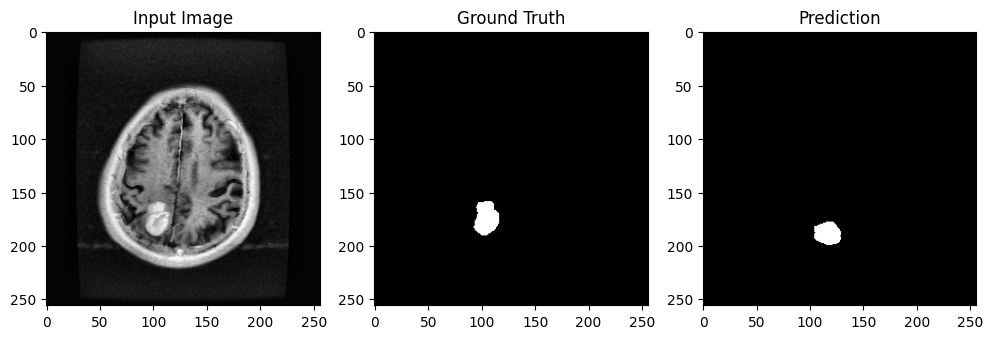

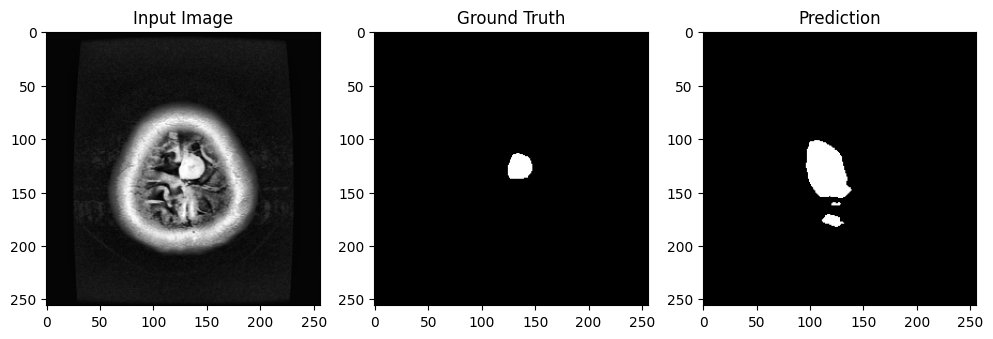

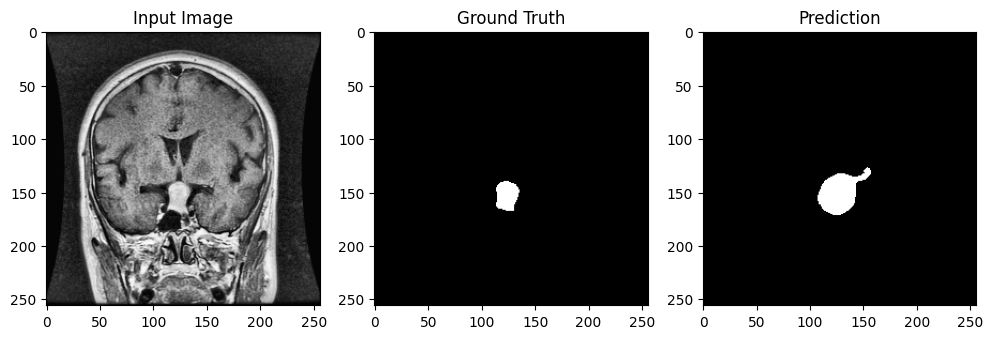

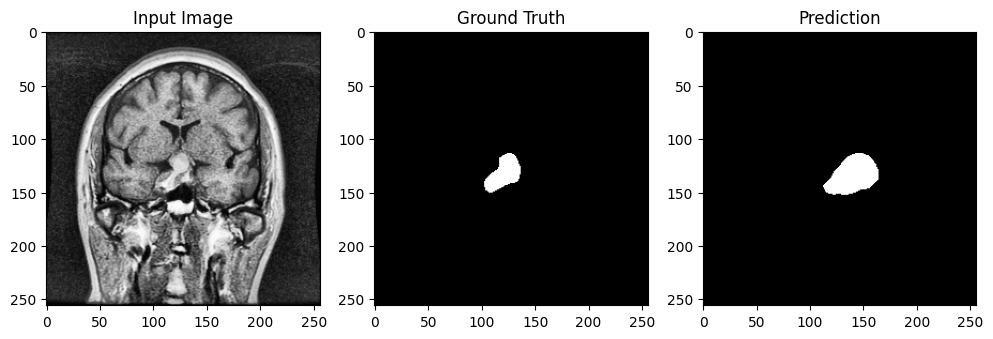

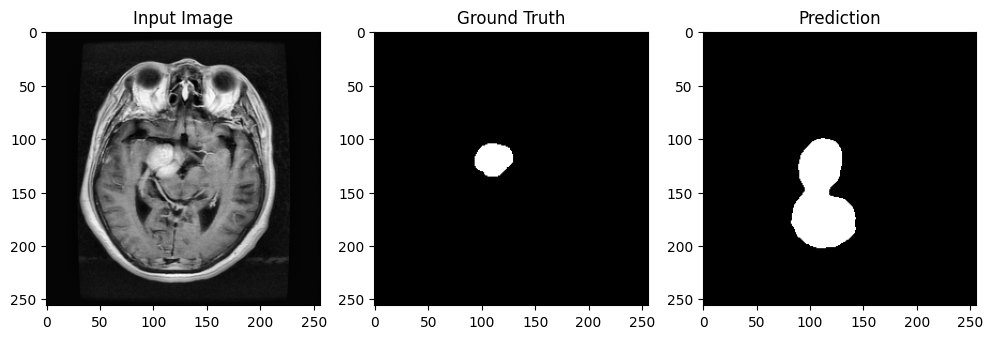

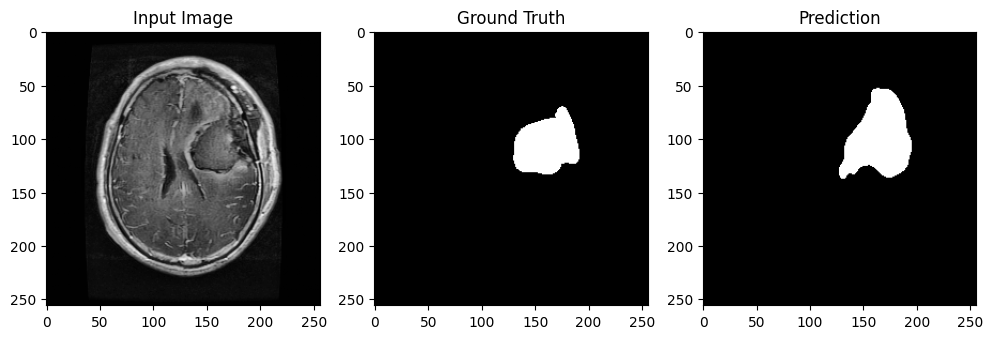

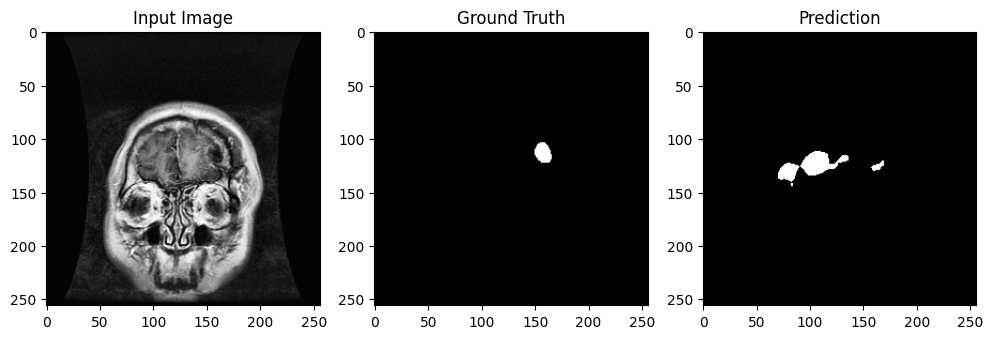

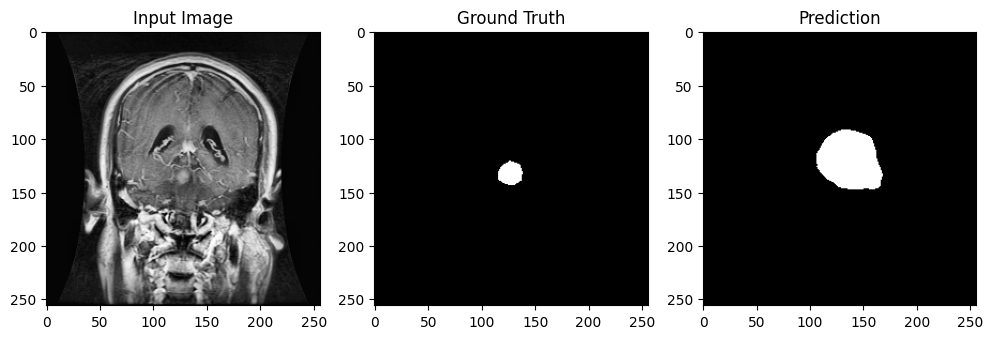

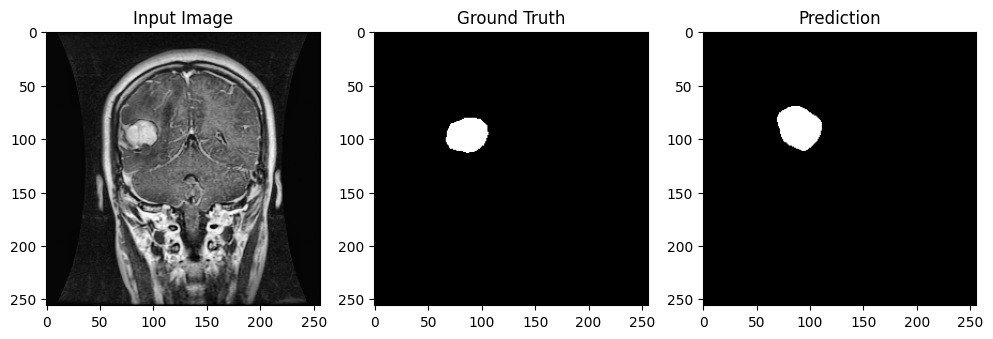

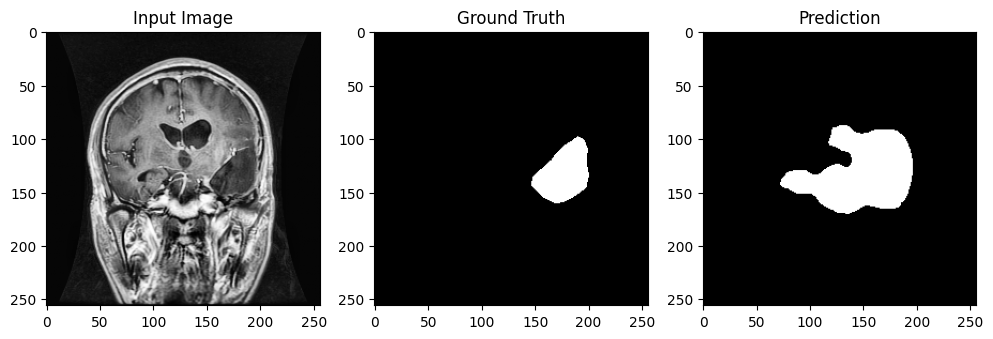

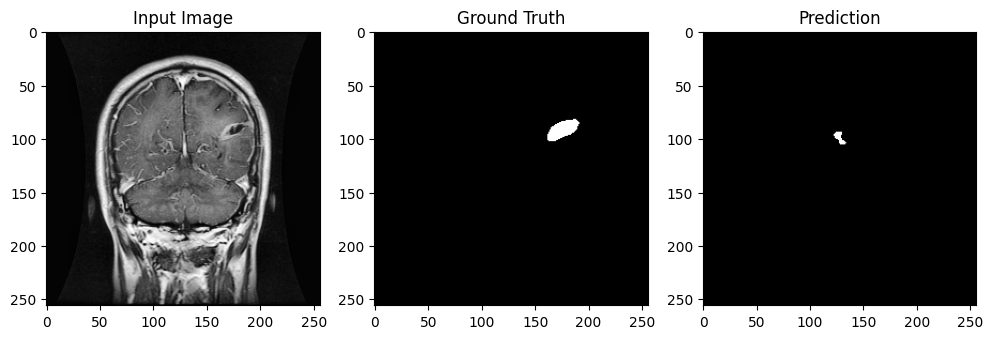

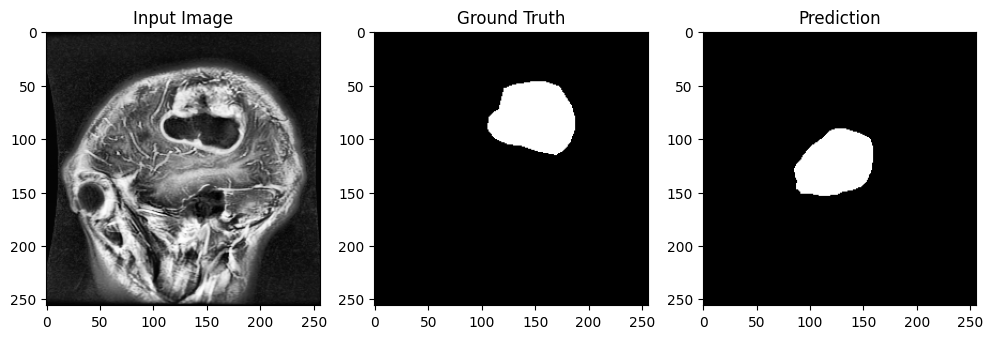

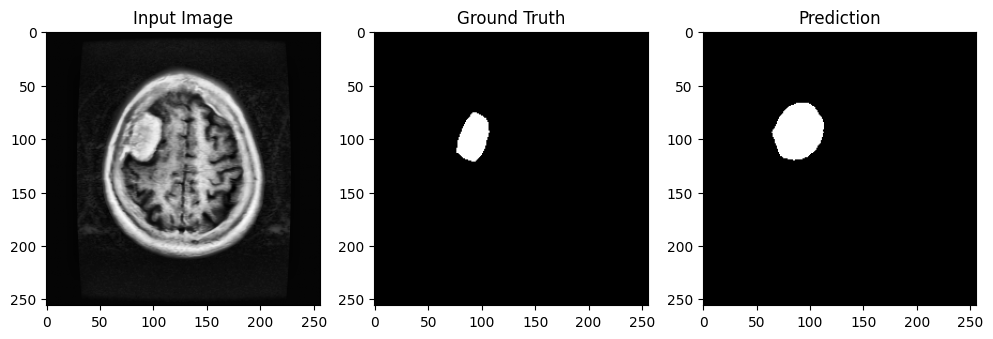

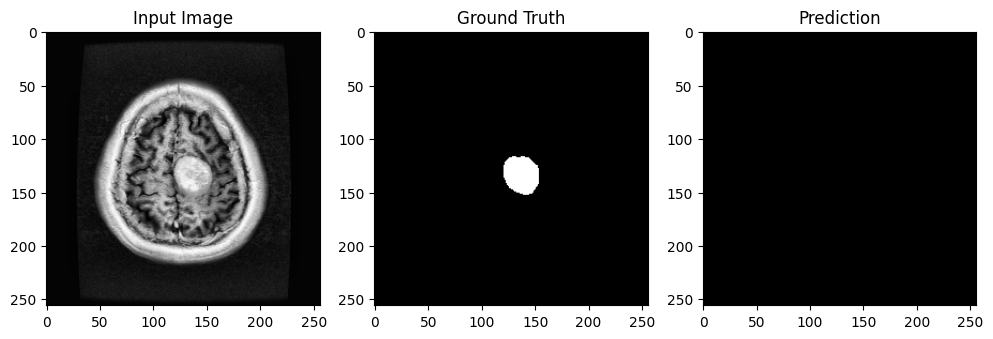

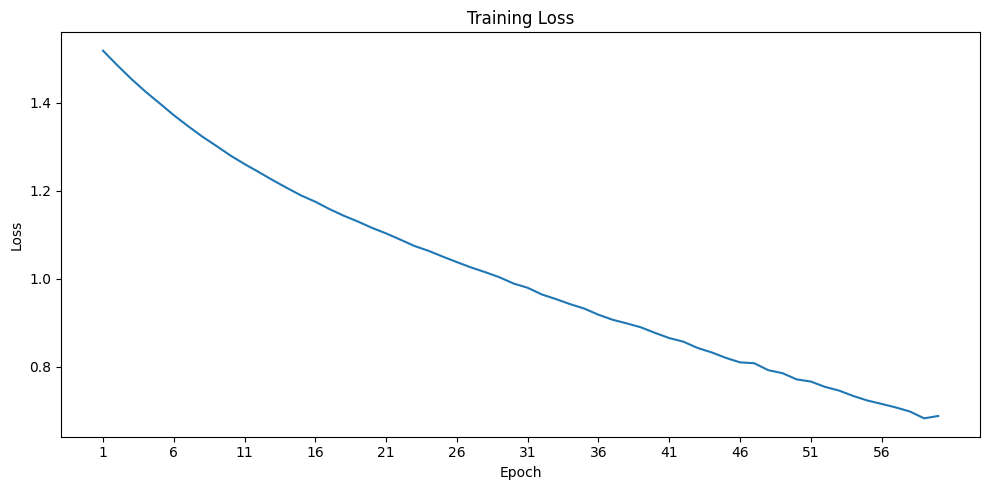

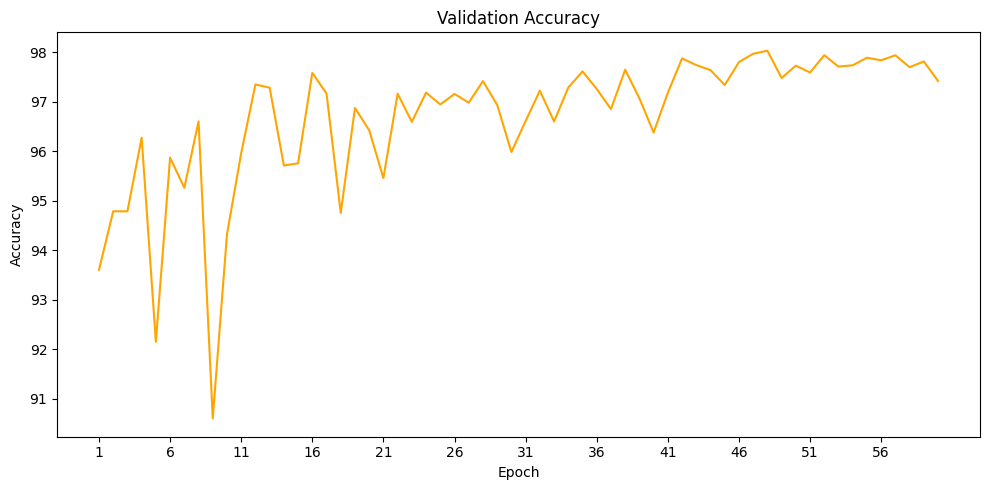

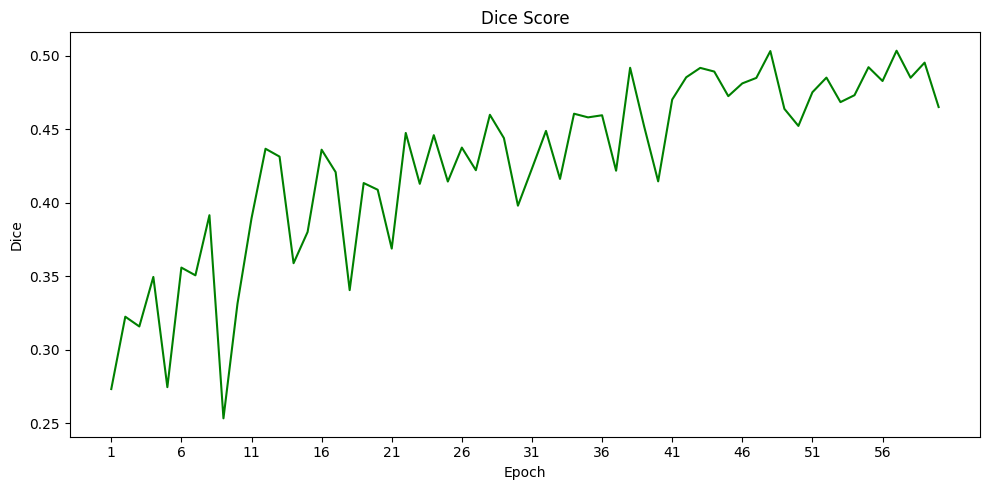

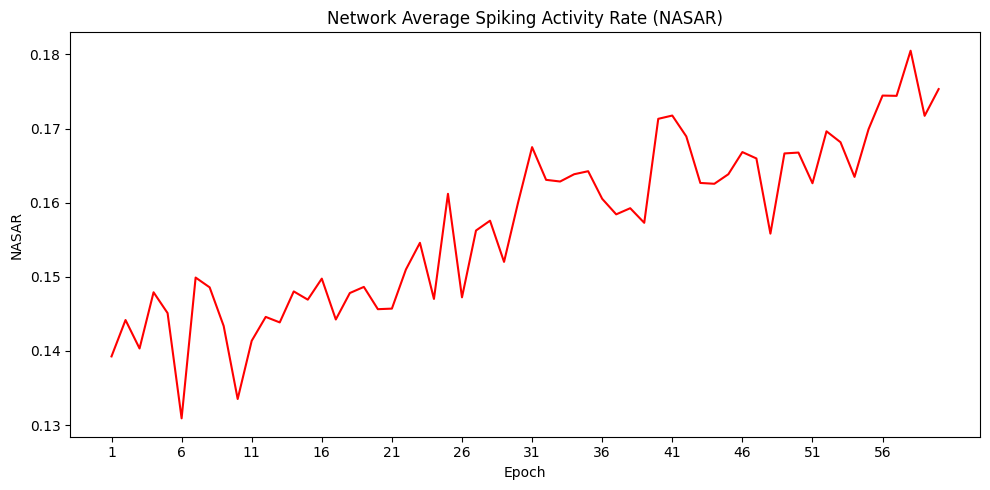

In [20]:
if __name__ == "__main__":
    main()

## Grad-CAM

In [21]:
def load_and_preprocess_image(image_path):
    transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.0), std=(1.0), max_pixel_value=255.0),
    ToTensorV2(),
    ])
    image = Image.open(image_path).convert("L")
    image_rgb = Image.open(image_path).convert("RGB")
    processed = transform(image=np.array(image))
    input_tensor = processed['image'].unsqueeze(0)
    vis_image = np.array(image_rgb.resize((256, 256))) / 255.0
    return input_tensor, vis_image

def reshape_transform_csa(tensor):
    # If tensor shape is [B, C, T, H, W], convert to [B, C*T, H, W]
    if tensor.ndim == 5:
        B, C, T, H, W = tensor.size()
        return tensor.permute(0, 2, 1, 3, 4).reshape(B, T * C, H, W)
    elif tensor.ndim == 4:
        return tensor  # Already [B, C, H, W]
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")
    
def reshape_transform_spiking(tensor):
    """Special reshape for spiking networks with attention"""
    if tensor.ndim == 5:  # [T,B,C,H,W]
        # For attention weights
        if tensor.shape[2] == 1:  # Attention mask case
            return tensor.mean(dim=0).mean(dim=1)  # [B,H,W]
        
        # For regular feature maps
        B, C, T, H, W = tensor.permute(1,2,0,3,4).shape
        return tensor.permute(1,0,2,3,4).reshape(B, T*C, H, W)
    
    elif tensor.ndim == 4:  # [B,C,H,W]
        return tensor
    
    raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

In [22]:
def generate_gradcam_grid_multi_layers(
    model,
    image_paths,
    mask_paths,
    target_layers_dict,
    device="cuda",
    save_folder="Att_Res_SNN_gradcam_results",
    grid_rows=3,
    grid_cols=6
    ):
    os.makedirs(save_folder, exist_ok=True)
    model.to(device).eval()

    selected = random.sample(list(zip(image_paths, mask_paths)), grid_rows * grid_cols)

    for layer_name, target_layer in target_layers_dict.items():

        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        layer_folder_name = f"{layer_name.replace('.', '_').replace('[', '_').replace(']', '')}_{timestamp}"
        layer_folder = os.path.join(save_folder, layer_folder_name)
        os.makedirs(layer_folder, exist_ok=True)

        cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform_csa)
        # cam = GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform_spiking)

        fig_cam, axes_cam = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        fig_mask, axes_mask = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 4, grid_rows * 4))
        fig_idx = 0

        for img_path, mask_path in selected:
            input_tensor, vis_image = load_and_preprocess_image(img_path)
            input_tensor = input_tensor.to(device)

            mask_tensor, _ = load_and_preprocess_image(mask_path)
            input_mask_tensor = mask_tensor.squeeze(0).cpu().numpy()

            targets = [SemanticSegmentationTarget(0, input_mask_tensor)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
            binary_seg_mask = (grayscale_cam > 0.8).astype(np.uint8)

            # Save CAM image
            cam_image = show_cam_on_image(vis_image, grayscale_cam, use_rgb=True)
            cam_save_path = os.path.join(layer_folder, f"cam_{os.path.basename(img_path)}")
            plt.imsave(cam_save_path, cam_image)

            # Save binary segmentation mask
            bin_mask_path = os.path.join(layer_folder, f"mask_{os.path.basename(img_path)}")
            plt.imsave(bin_mask_path, binary_seg_mask, cmap='gray')

            row = fig_idx // grid_cols
            col = fig_idx % grid_cols

            if row < grid_rows:
                axes_cam[row, col].imshow(cam_image)
                axes_cam[row, col].axis("off")
                axes_cam[row, col].set_title(f"{os.path.basename(img_path)}")

                axes_mask[row, col].imshow(binary_seg_mask, cmap='gray')
                axes_mask[row, col].axis("off")
                axes_mask[row, col].set_title(f"{os.path.basename(img_path)}")

                fig_idx += 1

        # Save full CAM grid
        grid_cam_path = os.path.join(layer_folder, f"grid_cam_{layer_name}_{timestamp}.png")
        plt.tight_layout()
        fig_cam.savefig(grid_cam_path)
        plt.close(fig_cam)

        # Save full binary segmentation mask grid
        grid_mask_path = os.path.join(layer_folder, f"grid_mask_{layer_name}_{timestamp}.png")
        plt.tight_layout()
        fig_mask.savefig(grid_mask_path)
        plt.close(fig_mask)

        print(f"✅ Saved {grid_cam_path}")
        print(f"✅ Saved {grid_mask_path}")

In [23]:
model = resnet_2.resnet34().to(device)
# checkpoint = torch.load("E:/Code/Attention-SNN/Att_Res_SNN_checkpoints/Att_Res_SNN_checkpoint_40_2025-04-14_08-50-42.pth.tar", map_location="cuda")
checkpoint = torch.load("E:/Code/Spiking-Visual-attention-for-Medical-image-segmentation/Att_Res_SNN_checkpoints/Att_Res_SNN_checkpoint_37_2025-04-24_10-21-23.pth.tar", map_location="cuda")
model.load_state_dict(checkpoint["state_dict"])

image_paths = sorted(glob.glob(os.path.join(VAL_IMG_DIR, "*.png")))
mask_paths = sorted(glob.glob(os.path.join(VAL_MASK_DIR, "*.png")))

target_layers = {
    "conv2_attention_sa": model.conv2_x[-1].residual_function[-1].attention.sa.conv,
    "conv3_attention_sa": model.conv3_x[-1].residual_function[-1].attention.sa.conv,
    
    "conv4_attention_sa": model.conv4_x[-1].residual_function[-1].attention.sa.conv,
    "conv4_residual":     model.conv4_x[-1].residual_function[-1],
    "conv4":              model.conv4_x[-1],

    "conv5_attention_sa": model.conv5_x[-1].residual_function[-1].attention.sa.conv,
    "conv5_residual":     model.conv5_x[-1].residual_function[-1],
    "conv5":              model.conv5_x[-1],

    "segmentation_layer_layers[0]": model.segmentation_layer.layers[0],
    "segmentation_layer_layers[1]": model.segmentation_layer.layers[1],
    "segmentation_layer_layers[2]": model.segmentation_layer.layers[2],
    "segmentation_layer_layers[3]": model.segmentation_layer.layers[3],
    "segmentation_layer_layers[4]": model.segmentation_layer.layers[4],
}

generate_gradcam_grid_multi_layers(
    model=model,
    image_paths=image_paths,
    mask_paths=mask_paths,
    target_layers_dict=target_layers,
    device=device,
    save_folder="Att_Res_SNN_gradcam_results",
    grid_rows=3,
    grid_cols=6
)

✅ Saved Att_Res_SNN_gradcam_results\conv4_attention_sa_20250424-141219\grid_cam_conv4_attention_sa_20250424-141219.png
✅ Saved Att_Res_SNN_gradcam_results\conv4_attention_sa_20250424-141219\grid_mask_conv4_attention_sa_20250424-141219.png
✅ Saved Att_Res_SNN_gradcam_results\conv4_residual_20250424-141229\grid_cam_conv4_residual_20250424-141229.png
✅ Saved Att_Res_SNN_gradcam_results\conv4_residual_20250424-141229\grid_mask_conv4_residual_20250424-141229.png
✅ Saved Att_Res_SNN_gradcam_results\conv4_20250424-141241\grid_cam_conv4_20250424-141241.png
✅ Saved Att_Res_SNN_gradcam_results\conv4_20250424-141241\grid_mask_conv4_20250424-141241.png
✅ Saved Att_Res_SNN_gradcam_results\conv5_attention_sa_20250424-141249\grid_cam_conv5_attention_sa_20250424-141249.png
✅ Saved Att_Res_SNN_gradcam_results\conv5_attention_sa_20250424-141249\grid_mask_conv5_attention_sa_20250424-141249.png
✅ Saved Att_Res_SNN_gradcam_results\conv5_residual_20250424-141258\grid_cam_conv5_residual_20250424-141258.png
✅

In [ ]:
summarize_eco2ai_log("attentionSNN_eco2ai_logs.csv")

In [ ]:
from google.colab import files

# Download the best Checkpoint
files.download('Att_Res_SNN_checkpoints/')

# Download the Saved Images Results
!zip -r Att_Res_SNN_saved_images.zip Att_Res_SNN_saved_images
files.download('Att_Res_SNN_saved_images.zip')

# Download the Grad-CAM Results
!zip -r Att_Res_SNN_gradcam_results.zip Att_Res_SNN_gradcam_results
files.download('Att_Res_SNN_gradcam_results.zip')

# Download the Eco2AI Logs
files.download("attentionSNN_eco2ai_logs.csv")